In [1]:
from google.colab import drive
drive.mount("/content/drive")
# @title Mount Drive

Mounted at /content/drive


In [3]:
!cd ~/

colab_ssh_zipfile_dir = "/content/drive/MyDrive"
colab_ssh_zipfile_name = "colab_ssh.zip"
colab_ssh_zipfile = colab_ssh_zipfile_dir + '/' + colab_ssh_zipfile_name

my_user_email = "momi.davide89@gmail.com"
my_user_name = "Davi1990"

! cd ~/

# Copy over and unzip the persistent ssh info file created in Step 2 
! cp $colab_ssh_zipfile .
! unzip $colab_ssh_zipfile_name
! cp root/.ssh/* /root/.ssh/

# Add ssh info to known hosts
! rm -rf root $colab_ssh_zipfile_name
! chmod 700 /root/.ssh
! ssh-keyscan github.com >> /root/.ssh/known_hosts
! chmod 644 /root/.ssh/known_hosts

# Add user info 
! git config --global user.email $my_user_email
! git config --global user.name $my_user_name

# Confirm user info registered correctly
!git config --global --get user.email
!git config --global --get user.name

# Test github access
! ssh git@github.com

Archive:  colab_ssh.zip
   creating: root/.ssh/
  inflating: root/.ssh/id_rsa        
  inflating: root/.ssh/id_rsa.pub    
# github.com:22 SSH-2.0-babeld-406cafbd
# github.com:22 SSH-2.0-babeld-406cafbd
# github.com:22 SSH-2.0-babeld-406cafbd
momi.davide89@gmail.com
Davi1990
PTY allocation request failed on channel 0
Hi Davi1990! You've successfully authenticated, but GitHub does not provide shell access.
Connection to github.com closed.


In [4]:
%%capture
!pip install mne


import os
os.chdir('/content/drive/MyDrive/TORONTO/EEG/reproduce_fig')

#!git clone git@github.com:GriffithsLab/tepfit --quiet
!git clone git@github.com:/Davi1990/PyTepFit


# @title Install dependencies

In [6]:
#%config Completer.use_jedi = False

import torch
import pickle
import numpy as np 
import glob
import re
import os
import matplotlib.pyplot as plt
import scipy, sklearn
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import io
import mne
import pandas as pd
import time
os.chdir('/content/drive/MyDrive/TORONTO/EEG/reproduce_fig/PyTepFit/tepfit/')
from fit import ParamsJR, Model_fitting, RNNJANSEN, Costs, OutputNM

# @title Importage

In [7]:
files_dir =  '/content/drive/MyDrive/TORONTO/EEG'

pck_files = sorted(glob.glob(files_dir + '/*_fittingresults_stim_exp.pkl'))
pck_files.pop()
pck_files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

In [19]:
with open(pck_files[2], 'rb') as f:
    data = pickle.load(f)
    
keys=[]
for i in vars(data.output_sim).keys():
    keys.append(i)

In [20]:
keys.remove('output_name')


for k in keys:
    variable_name = 'all_' + k
    if (k == 'E_train' or k == 'E_test' or k =='Ev_train' or k == 'Ev_test' or k =='I_train'
        or k =='I_test' or k =='Iv_train' or k =='Iv_test' or k =='P_train' or k =='P_test' or k =='Pv_train'
        or k =='Pv_test' or k =='EEG_train' or k =='EEG_test'):
      
        exec(variable_name + " =  np.zeros((len(pck_files), getattr(data.output_sim, k).shape[0], getattr(data.output_sim, k).shape[1]))")
    elif(k =='y0' or k == 'y0_m' or k =='y0_v' or k == 'leadfield'):
        exec(variable_name + " =  np.zeros((len(pck_files), getattr(data.output_sim, k).shape[1]))")
    elif(k =='weights'):
         exec(variable_name + " =  np.zeros((len(pck_files), round(np.sqrt(data.output_sim.weights.shape[1]*2)+1), \
                                            round(np.sqrt(data.output_sim.weights.shape[1]*2)+1)))")
    elif(k =='lm'):
         exec(variable_name + " =  np.zeros((len(pck_files), 62, 200))")  
    else:
         exec(variable_name + " =  np.zeros((len(pck_files)))")
    

for sub in range(len(pck_files)):
    with open(pck_files[sub], 'rb') as f:
        data = pickle.load(f)            
    for k in keys:
        variable_name = 'all_' + k
        if (k == 'E_train' or k == 'E_test' or k =='Ev_train' or k == 'Ev_test' or k =='I_train'
            or k =='I_test' or k =='Iv_train' or k =='Iv_test' or k =='P_train' or k =='P_test' or k =='Pv_train'
            or k =='Pv_test' or k =='EEG_train' or k =='EEG_test'):
            exec(variable_name + "[sub,:,:] =  getattr(data.output_sim, k)")
        elif (k =='y0' or k == 'y0_m' or k =='y0_v'):
            exec(variable_name + "[sub,:] =  getattr(data.output_sim, k)[-1]")
        elif (k == 'lm'):
            lm_mod =np.mean(getattr(data.output_sim, k)[-10:,:], axis=0)
            lm_mod = lm_mod.reshape(62,200)
            exec(variable_name + "[sub,:,:] =  lm_mod")
            #exec(variable_name + "[sub,:] =  np.mean(getattr(data.output_sim, k)[-10:,:], axis=0)")
        elif (k == 'weights'):
            sc_mod = np.zeros((200,200))
            mask = np.tril_indices(200,-1)
            sc_mod[mask] =np.mean(getattr(data.output_sim, k)[-10:,:], axis=0)
            sc_mod = sc_mod+sc_mod.T
            exec(variable_name + "[sub,:,:] =  sc_mod")
        elif (k == 'loss'):
            exec(variable_name + "[sub] =  getattr(data.output_sim, k)[-1]")
        else:
             exec(variable_name + "[sub] = getattr(data.output_sim, k)[-1][0]")


all_params = {}

for i in keys:
    variable_name = 'all_' + keys[keys.index(i)]
    all_params[i] = locals()[variable_name]
    
# @title Import all subjects' new data 

In [22]:
df = {}
for j in keys[15:-5]:
  df[j] = all_params[j]

sim_eeg = []
for sbj2import in range(len(pck_files)):
  with open(pck_files[sbj2import], 'rb') as f:
      data = pickle.load(f)

  sim_eeg.append(data.output_sim.eeg_test)

sim_eeg = np.array(sim_eeg)



new_df = pd.DataFrame(df[list(df.keys())[0]],columns=[list(df.keys())[0]]) 

for j in range(1,len(keys[15:-5])):
    if len(df[list(df.keys())[j]].shape) > 1:
      continue
    new_df[list(df.keys())[j]] = df[list(df.keys())[j]]

# @title Put everything in a dataframe  

In [23]:
new_df.head()

,a,a_m,a_v,b,b_m,b_v,c1,c1_m,c1_v,c2,...,g_m,g_v,k,k_m,k_v,lm_m,lm_v,mu,mu_m,mu_v
0,99.347740,99.349411,13.423514,51.732155,51.726952,20.234665,134.248627,134.247910,15.177748,109.359291,...,1005.619690,-0.074119,8.622959,8.625903,15.825628,-0.196908,20.221025,0.724521,0.724521,26.806150
1,97.902908,97.906097,17.277964,50.919029,50.916897,21.416142,132.442017,132.439331,3.653811,109.313416,...,995.456909,1.669649,8.491941,8.496260,14.088799,-0.196908,20.221025,1.257499,1.257499,26.730782
2,96.159073,96.155228,17.785526,48.930202,48.930965,19.242479,132.071304,132.070389,3.482142,109.954453,...,1003.956848,-0.067157,5.207799,5.204693,15.579039,-0.196908,21.321537,0.884640,0.887312,27.587242
3,97.962982,97.962212,18.689106,49.428665,49.424057,19.966417,140.498962,140.497177,2.006927,110.167084,...,1001.788818,12.220649,7.374860,7.377864,14.998615,-0.196908,20.221025,1.154494,1.151102,26.320961
4,97.748863,97.741402,17.297514,49.748447,49.753254,20.375174,136.682190,136.682266,18.854050,110.326828,...,1000.929321,12.901804,8.237830,8.241162,3.475570,-0.196908,20.221012,1.025875,1.021145,26.105455


In [24]:
new_df1 = new_df[['a', 'b', 'c1', 'c2', 'c3', 'c4', 'g', 'k', 'mu']]
new_df1.head()
# @title Extract meaningful params

,a,b,c1,c2,c3,c4,g,k,mu
0,99.347740,51.732155,134.248627,109.359291,30.855425,31.841507,1010.790710,8.622959,0.724521
1,97.902908,50.919029,132.442017,109.313416,31.667231,32.310017,995.457092,8.491941,1.257499
2,96.159073,48.930202,132.071304,109.954453,31.920504,33.160477,1006.695007,5.207799,0.884640
3,97.962982,49.428665,140.498962,110.167084,27.849882,31.195692,1001.789185,7.374860,1.154494
4,97.748863,49.748447,136.682190,110.326828,31.616518,33.609516,1000.929565,8.237830,1.025875


$a$ = Reciprocal of the time constant of passive membrane and all other spatially distributed delays in the dendritic network $[ms^-1]$. Also called average synaptic time constant

$b$ = Reciprocal of the time constant of passive membrane and all other spatially distributed delays in the dendritic network $[ms^-1]$. Also called average synaptic time constant

$c1$ = Average probability of synaptic contacts in the feedback excitatory loop. Local gain from E to P

$c2$ = Average probability of synaptic contacts in the slow feedback excitatory loop. Local gain from P to E

$c3$ = Average probability of synaptic contacts in the feedback inhibitory loop. Local gain from I to P

$c4$ = Average probability of synaptic contacts in the slow feedback inhibitory loop. Local gain from P to I

$g$ = global gain

$k$ = adjust the magnitude of EEG signal (probably not meaniningful)

$mu$ = Mean input firing rate

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

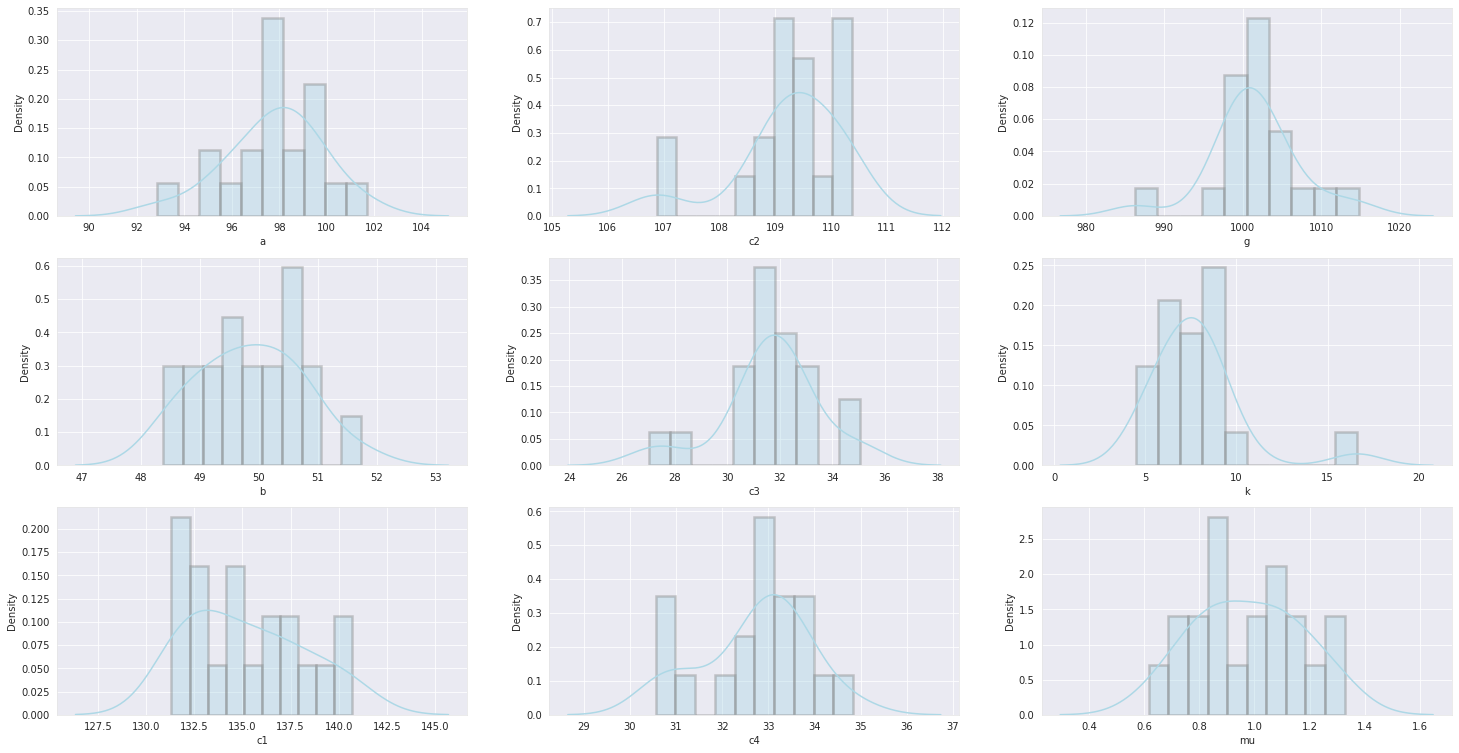

In [25]:
sns.set_style('darkgrid',{'axes.edgecolor': '.9'},)
f, ax = plt.subplots(3,3,figsize = (25,13))
plt.rcParams["patch.force_edgecolor"] = True

row = 0
col = 0

for k in new_df1.keys():
  sns.distplot(new_df1[k],bins=10,color='lightblue', hist_kws=dict(edgecolor="grey", linewidth=2.5),ax=ax[row][col])
  #sns.displot(new_df1[k], bins=10, ax=ax[row][col])
  row=row+1
  if row>2:
    row=0
    col=col+1

#f.savefig('/content/drive/MyDrive/TORONTO/TMS_EEG_model/saving-a-high-resolution-seaborn-plot.png', dpi=300)


<ipython-input-30-e2e53cb49f1b>:6: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)
<ipython-input-30-e2e53cb49f1b>:14: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)


Text(0.5, 1.0, 'eigenvector#3 variance explained 3.95%')

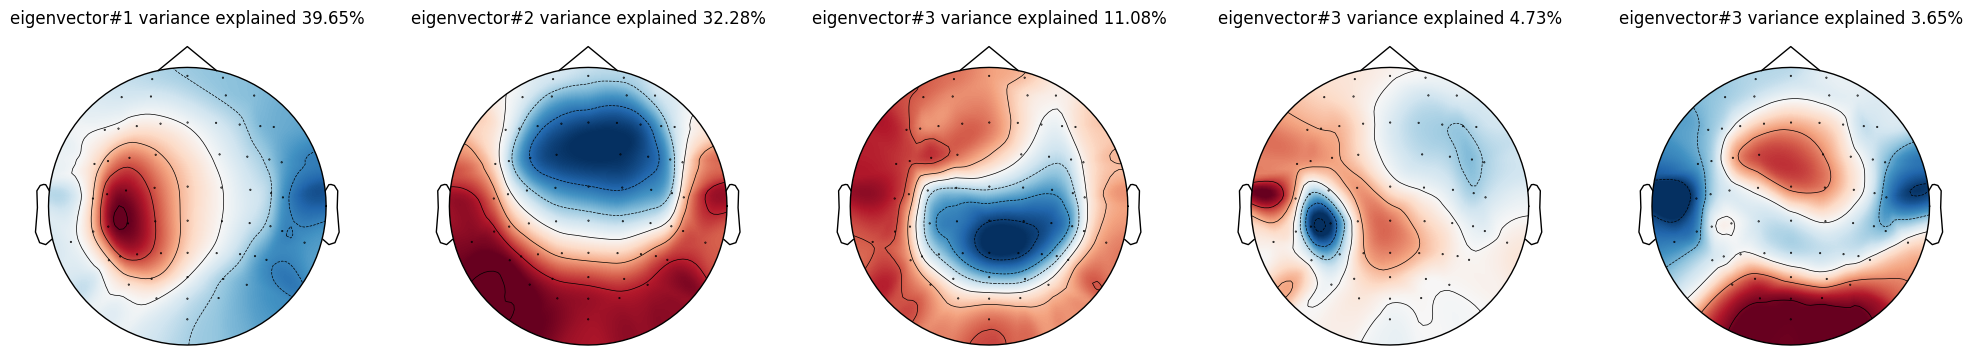

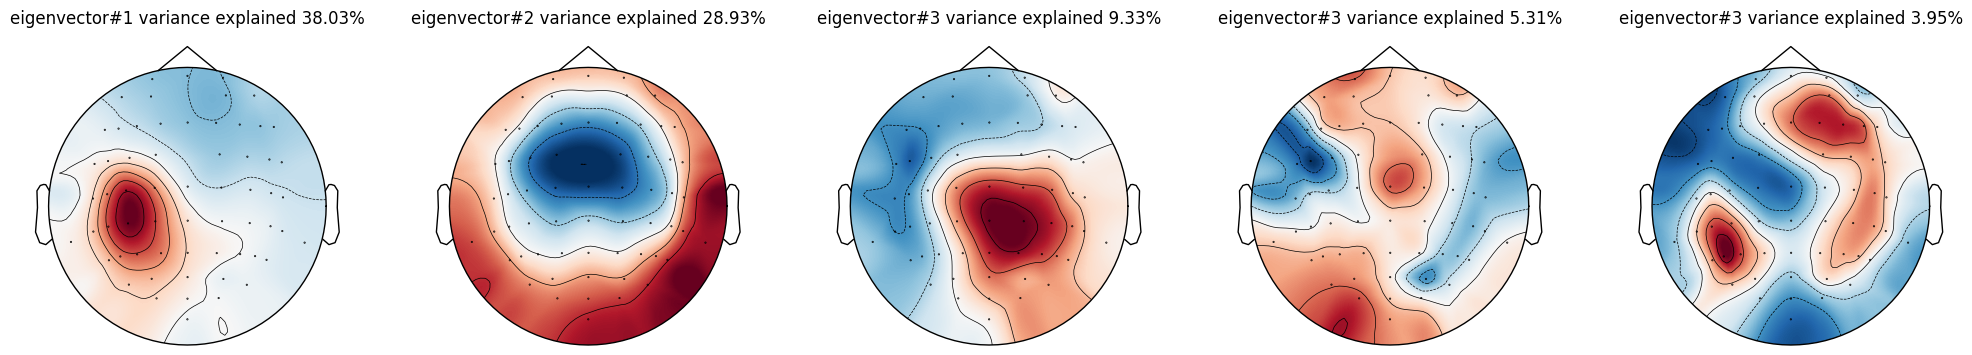

In [30]:
plt.style.use('default')

xmin = -0.05
xmax = 0.3

epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)
evoked = epochs.average()

A = evoked.data[:,np.where(evoked.times==xmin)[0][0]:np.where(evoked.times==xmax)[0][0]]
U,S,V = np.linalg.svd(A)
S_PC = (100*S)/(np.sum(S))


epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)

for sbj in range(epochs._data.shape[0]):
  epochs._data[sbj,:,900:1300] = sim_eeg[sbj,:,:]


evoked = epochs.average()
A = evoked.data[:,np.where(evoked.times==xmin)[0][0]:np.where(evoked.times==xmax)[0][0]]

U_sim,S_sim,V_sim = np.linalg.svd(A)
S_PC_sim = (100*S_sim)/(np.sum(S_sim))

fig, axes = plt.subplots(figsize=(25, 5), nrows=1, ncols=5)


mne.viz.plot_topomap(U_sim[:, 0], epochs.info, show=False, axes=axes[0])
axes[0].set_title('eigenvector#' + str(1) + ' variance explained ' + str(round(S_PC_sim[0],2)) + '%')
mne.viz.plot_topomap(U_sim[:, 1], epochs.info, show=False, axes=axes[1])
axes[1].set_title('eigenvector#' + str(2) + ' variance explained ' + str(round(S_PC_sim[1],2)) + '%')
mne.viz.plot_topomap(U_sim[:, 2], epochs.info, show=False, axes=axes[2])
axes[2].set_title('eigenvector#' + str(3) + ' variance explained ' + str(round(S_PC_sim[2],2)) + '%')
mne.viz.plot_topomap(U_sim[:, 3], epochs.info, show=False, axes=axes[3])
axes[3].set_title('eigenvector#' + str(3) + ' variance explained ' + str(round(S_PC_sim[3],2)) + '%')
mne.viz.plot_topomap(U_sim[:, 4], epochs.info, show=False, axes=axes[4])
axes[4].set_title('eigenvector#' + str(3) + ' variance explained ' + str(round(S_PC_sim[4],2)) + '%')



fig, axes = plt.subplots(figsize=(25, 5), nrows=1, ncols=5)

mne.viz.plot_topomap(U[:, 0], epochs.info, show=False, axes=axes[0])
axes[0].set_title('eigenvector#' + str(1) + ' variance explained ' + str(round(S_PC[0],2)) + '%')
mne.viz.plot_topomap(-U[:, 1], epochs.info, show=False, axes=axes[1])
axes[1].set_title('eigenvector#' + str(2) + ' variance explained ' + str(round(S_PC[1],2)) + '%')
mne.viz.plot_topomap(U[:, 2], epochs.info, show=False, axes=axes[2])
axes[2].set_title('eigenvector#' + str(3) + ' variance explained ' + str(round(S_PC[2],2)) + '%')
mne.viz.plot_topomap(U[:, 3], epochs.info, show=False, axes=axes[3])
axes[3].set_title('eigenvector#' + str(3) + ' variance explained ' + str(round(S_PC[3],2)) + '%')
mne.viz.plot_topomap(U[:, 4], epochs.info, show=False, axes=axes[4])
axes[4].set_title('eigenvector#' + str(3) + ' variance explained ' + str(round(S_PC[4],2)) + '%')

In [31]:
comp_n=0
start_tp = 140
end_tp = 230
ts2use = 'simulated' # 'empirical' or 'simulated'


max_similairty = []
for sbj in range(epochs._data.shape[0]):
  similarity = []

  for tp in range(start_tp,sim_eeg[sbj,:,:].shape[1]-end_tp):
    if ts2use == 'empirical':
      similarity.append(1 - scipy.spatial.distance.cosine(np.abs(U[:, comp_n]), np.abs(epochs._data[sbj,:,900+tp])))
    else:
      similarity.append(1 - scipy.spatial.distance.cosine(np.abs(U_sim[:, comp_n]), np.abs(sim_eeg[sbj,:,tp])))

  similarity = np.array(similarity)
  max_similairty.append(np.where(similarity == np.max(similarity))[0][0])


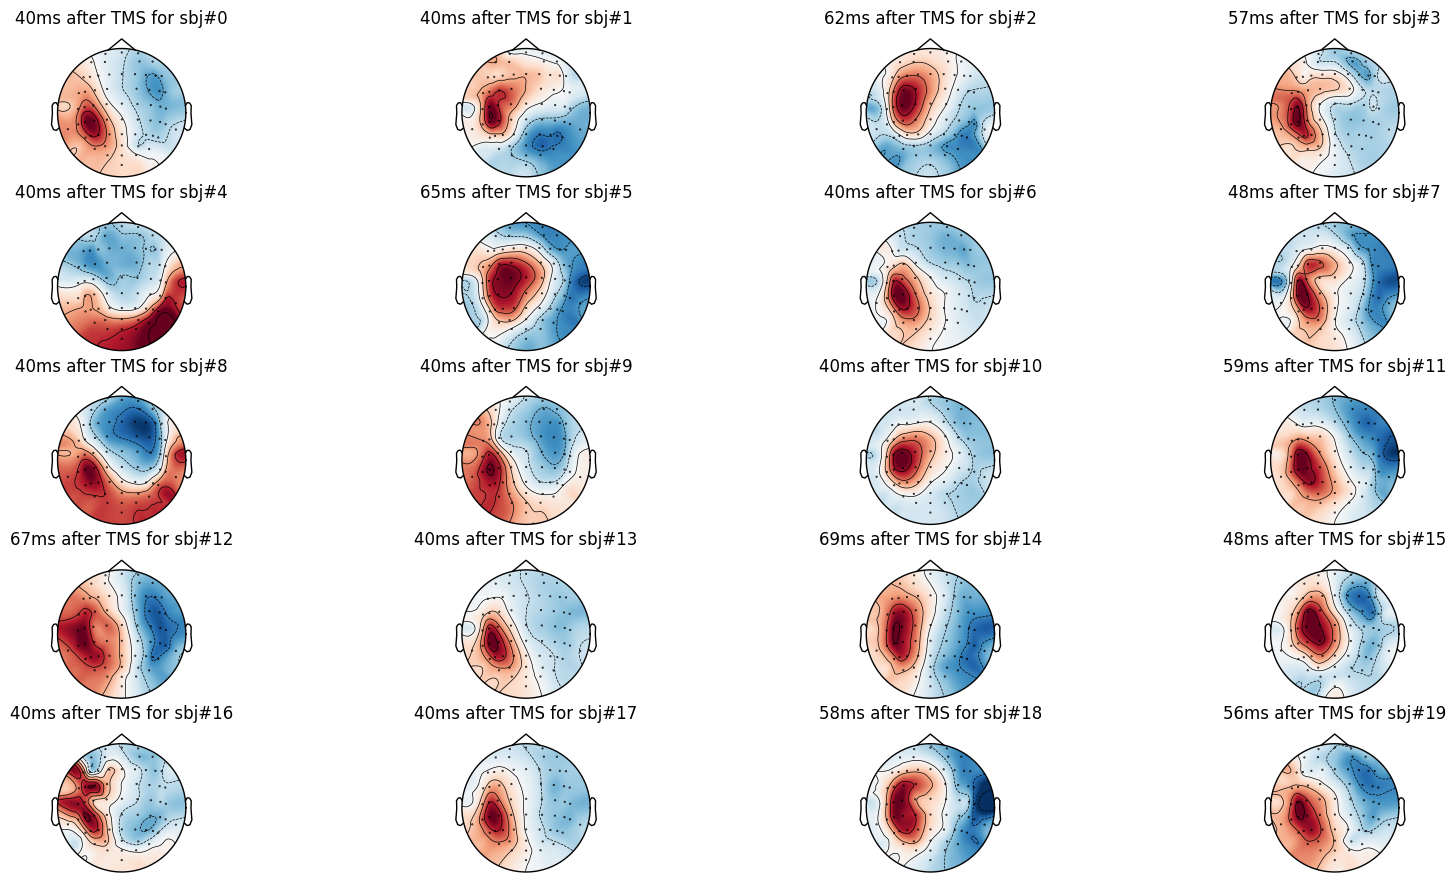

In [32]:
nrows = 5
ncols=4 

fig, axes = plt.subplots(figsize=(20, 10), nrows=nrows, ncols=ncols)

sbj=0

for axes_row in range(nrows):
    for ax in range(ncols):
      if ts2use == 'empirical':
        mne.viz.plot_topomap(epochs._data[sbj,:,900+max_similairty[sbj]+start_tp], epochs.info, show=False, axes=axes[axes_row,ax])
      else:
        mne.viz.plot_topomap(sim_eeg[sbj,:,max_similairty[sbj]+start_tp], epochs.info, show=False, axes=axes[axes_row,ax])
      axes[axes_row,ax].set_title(str(max_similairty[sbj] + start_tp - 100) + 'ms after TMS for sbj#' + str(sbj))
      sbj=sbj+1

    sbj=sbj

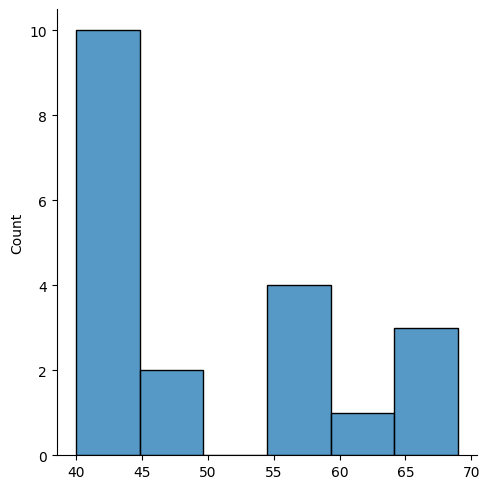

In [33]:
sns.displot(np.array(max_similairty) + start_tp - 100)


In [35]:
epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)
evoked = epochs.average()


peaks_locs = (np.array(max_similairty))/1000

first_ch = []
fist_peak_locs = []
fist_peak_amp = []


for xx in range(peaks_locs.shape[0]):
  sbj2import=xx
  single_EEG = evoked.copy()
  single_EEG.data = epochs._data[sbj2import,:,:]
  simulated_EEG = single_EEG.copy()
  simulated_EEG.data[:,900:1300]= sim_eeg[sbj2import,:,:]

  if ts2use == 'empirical':
    ch, peak_locs1, peak_amp1 = single_EEG.get_peak(ch_type='eeg', tmin=peaks_locs[xx], tmax=peaks_locs[xx], return_amplitude=True)
  else:
    ch, peak_locs1, peak_amp1 = simulated_EEG.get_peak(ch_type='eeg', tmin=peaks_locs[xx], tmax=peaks_locs[xx], return_amplitude=True)

  first_ch.append(ch)
  fist_peak_locs.append(peak_locs1)
  fist_peak_amp.append(peak_amp1)

first_ch = np.array(first_ch)
fist_peak_locs = np.array(fist_peak_locs)
fist_peak_amp = np.array(fist_peak_amp)



r_lat = []
p_lat = []
r_amp = []
p_amp = []

for j in new_df1.keys():


  r, p =  scipy.stats.pearsonr(new_df1[j], fist_peak_locs)
  r_lat.append(r)
  p_lat.append(p)

  r, p =  scipy.stats.pearsonr(new_df1[j], fist_peak_amp)
  r_amp.append(r)
  p_amp.append(p)

r_lat = np.array(r_lat)
p_lat = np.array(p_lat)
r_amp = np.array(r_amp)
p_amp = np.array(p_amp)

<ipython-input-35-83463315618c>:1: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)


In [36]:
print(np.where(p_amp<0.05))
print(np.where(p_lat<0.05))

(array([1, 7]),)
(array([1]),)


<ipython-input-37-1a9e8b72c6d9>:1: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)


outliers=[]


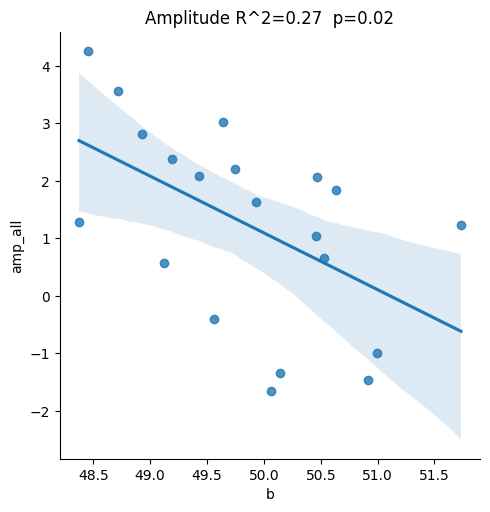

In [37]:
epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)

key2plot = 1
exclude_outliers = False
std_from_mean = 2
variable2plot = 'amplitude' # 'amplitude' or 'latency'

if variable2plot=='amplitude':
  data2plot = {'amp_all': fist_peak_amp, list(new_df1.keys())[key2plot]: new_df1[list(new_df1.keys())[key2plot]]}  
else:
  data2plot = {'lat_all': fist_peak_locs, list(new_df1.keys())[key2plot]: new_df1[list(new_df1.keys())[key2plot]]}  

  
# Create DataFrame  
df2plot = pd.DataFrame(data2plot)  

outlier = []

if exclude_outliers:
  std_up = df2plot[list(data2plot.keys())[0]].mean() + (std_from_mean*df2plot[list(data2plot.keys())[0]].std())
  std_down =df2plot[list(data2plot.keys())[0]].mean() - (std_from_mean*df2plot[list(data2plot.keys())[0]].std()) 
  if np.shape(np.where(df2plot[list(data2plot.keys())[0]]> std_up)[0])[0] > 0:
    outlier.append(np.where(df2plot[list(data2plot.keys())[0]]> std_up)[0][0])

  if np.shape(np.where(df2plot[list(data2plot.keys())[0]]< std_down)[0])[0] > 0:
    outlier.append(np.where(df2plot[list(data2plot.keys())[0]] < std_down)[0][0])


std_up = df2plot[list(new_df1.keys())[key2plot]].mean() + (std_from_mean*df2plot[list(new_df1.keys())[key2plot]].std()) 
std_down =df2plot[list(new_df1.keys())[key2plot]].mean() - (std_from_mean*df2plot[list(new_df1.keys())[key2plot]].std())

if exclude_outliers:
  if np.shape(np.where(df2plot[list(new_df1.keys())[key2plot]]< std_down)[0])[0] > 0:
    outlier.append(np.where(df2plot[list(new_df1.keys())[key2plot]]< std_down)[0][0])

  if np.shape(np.where(df2plot[list(new_df1.keys())[key2plot]]> std_up)[0])[0] > 0:
    outlier.append(np.where(df2plot[list(new_df1.keys())[key2plot]]> std_up)[0][0])



df2plot = df2plot.drop(outlier)
print('outliers=' + str(outlier))

sns.lmplot(x=list(new_df1.keys())[key2plot], y=list(data2plot.keys())[0], data=df2plot);
if variable2plot=='amplitude':
  plt.title('Amplitude R^2=' + str(round((r_amp[key2plot]**2),2)) + '  p=' + str(round(p_amp[key2plot],2)));
else:
  plt.title('Latency R^2=' + str(round((r_lat[key2plot]**2),2)) + '  p=' + str(round(p_lat[key2plot],2)));


In [38]:
param2use = 'b'

epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)
evoked = epochs.average()

sbj2plot = 18
percentage_variation = np.arange(10,100,10)
direction = 'decrease' # 'increase' or 'decrease'

gmfp=[]


for xx in percentage_variation:
  sbj2plot = int(sbj2plot)


  with open(pck_files[sbj2plot], 'rb') as f:
      data = pickle.load(f)



  data.model.batch_size = 50
  state_lb = 0
  state_ub = 5
  delays_max = 500
  base_batch_num = 20
  transient_num = 10
  node_size = 200 
  state_size = 6 

  empirical_ts = np.zeros((1, evoked.data.shape[0], evoked.data.shape[1]))
  empirical_ts[0] = evoked.data

  x0 = np.random.uniform(state_lb, state_ub, (node_size, state_size))
  he0 = np.random.uniform(state_lb, state_ub, (node_size, delays_max))



  if direction=='increase':
    original_value = getattr(data.model, param2use).detach().numpy()  + (getattr(data.model, param2use).detach().numpy()  * xx / 100)
    setattr(data.model, param2use,Parameter(torch.tensor(original_value, dtype=torch.float32)))
  else:
    original_value = getattr(data.model, param2use).detach().numpy()  - (getattr(data.model, param2use).detach().numpy()  * xx / 100)
    setattr(data.model, param2use,Parameter(torch.tensor(original_value, dtype=torch.float32)))  


  #0-400ms
  u = np.zeros((200,10,400))
  u[:,:,110:120]= 1000
  data.ts = empirical_ts[:,:,0:400]
  data.test(x0, he0,20, u=u)


  simulated_EEG_st=evoked.copy()
  simulated_EEG_st.data[:,900:1300] = data.output_sim.eeg_test
  gmfp.append((np.sum(simulated_EEG_st.data[:,950:1150] ** 2, axis=0).T - (np.mean(np.sum(simulated_EEG_st.data[:,950:1150] ** 2, axis=0))).T).T)

gmfp = np.array(gmfp)


<ipython-input-38-a64a51165a9d>:3: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1106: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


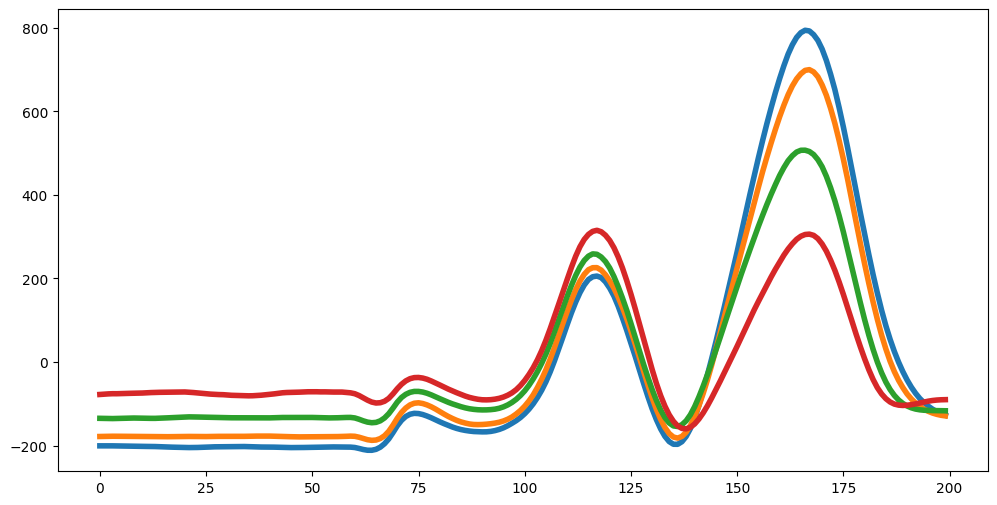

In [39]:
plt.rcParams['figure.figsize'] = (12, 6)

#for xx in range(gmfp.shape[0]):
for xx in range(1,9,2):
  ts2plot = gmfp[xx,:] - np.mean(gmfp[xx,:])
  leg_lines = plt.plot(ts2plot)
  plt.setp(leg_lines, linewidth=4)